In [1]:
from utils.tasks.complete_task import CompleteTask

# Pricing campaign

The objective in the pricing scenario is to learn the optimal price of our product to maximize the total revenue.\
In an everyday scenario a seller might try to negotiate the price of a good, trying to sell it for the maximum price at which the buyer would buy it. The seller while performing his job exploits the knowledge he has about the customers to increase his profit. 
The same can be done in our scenario, where we'll use reinforcement learning algorithms that will learn the optimal price of our product.
To explain how this algorithms work we need to introduce the concept of demand curve.
### Demand Curve
The demand curve is a function that maps the price of a good and the quantity of that good demanded at that price.
A _market demand curve_ can be used to model the price-quantity relationship for all consumers in a particular market.
The price-quantity relationship can also be expressed putting on the x-axis the price and on the y-axis the probability that a user will buy the good at that price, a function also defined as _conversion rate_. \
As shown in the introduction, we divide our customer using two binary features and we identify 3 different classes.
For each class we have a different conversion rate:
- __Class C1__: these are users that buy every day coffee online so they'll have an overall higher conversion rate, especially for the low prices. We  assumed that some users of this category might be interested in finer types of coffee with a high price. This is expressed with a strongly decreasing demand curve, which has only a slow increase at the end.
- __Class C2__: these mixed class includes users that either buy online but are not everyday consumers or that buy frequently coffee but are not accustomed to buying online. These kind of users are the one with the lowest interest in the product and this is shown by a overall low conversion rate. The curve is pretty much linearly decreasing with a low slope.
- __Class C3__: In this class there are the users that usually don't buy online and that aren't used to buy coffee. We tought that these kind of users might be more curious to try the product so the conversion rate is overall higher w.r.t. the class C2. The trend is again linearly decreasing.

Here it is the visual representation of the conversion rates:
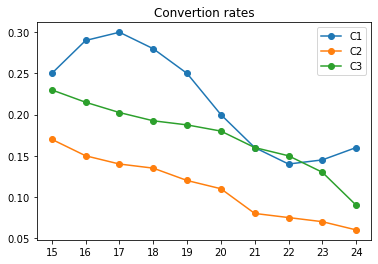



In the next section we will not discriminate the users on their class, so the _aggregate conversion rate_ must be computed as a weighted mean over the 3 conversion rates using as weights the fractions that represent the number of users belonging to the class over the total number of users.
The ending result is the following:
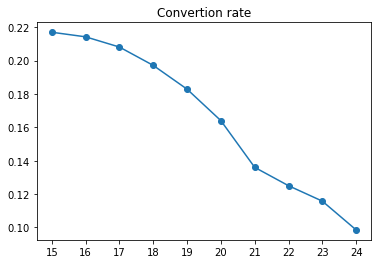

### Scenario
We'll start by considering the **aggregate** case, where we do not consider the differences between the festures of the various users.
Another important thing to consider is that in the pricing scenario we will assume all the variables depending on the bid as fixed.
Let's now reconsider our goal, which is to maximize the total revenue.
To do so we need to find the optimal price, which is the one that maximizes the profit  $n_j*(m_{p_j}*(\tau_{j}+1)*c_j-CPC{j})$.
Given that the number of clicks $n_j$, the margin $m_{p_j}$ and the cost per click $CPC{j}$ all depend on the bid and so are fixed in this scenario, our objective will be to find a proper estimation of the conversion rate $c_j$ and of the variable $\tau_{j}$and we'll do so through an iterative learning process. 
The main elements of our simulation are:

- __The Environment__
- __The Learner__



### Environment

The environment simulates the market in our implementation. It is a clairvoyant entity that knows a priori all the distributions of the various parameters related to the users, that are dependent on the bid and on the price. In the basic pricing scenario the bid is fixed so parameters depending on it, such as the cost per click $CPC_{j}$ and the number of clicks $n_{j}$, can be directly computed. 
The conversion rate $c_{j}$  and the number of times the user will buy again in the next 30 days $\tau_{j}$ are instead dependent on the price, so they will be computed day by day given the price $p$ chosen by the learner. \
Each day the environment iterates over the number of clicks and according to the conversion rate it samples the outcome of their decision (to buy or not to buy the product), communicating to the learner the class to which they belong.\
The environment is perceived from the outside as a black box and the only informations obtainable by the learner are the daily reward (i.e. a list composed by all the users' outcomes and their associated $CPC_{j}$) and the number of additional purchases per day that is computed using $\tau_{j}$. It is important to notice that the latter is an information that will only be shared with the learner 30 days from when the purchase happened.


### Learner

The learner's task is to find the optimal price of the product by interacting with the environment. This mechanism can be implemented through a Multi-Armed Bandit (MAB) algorithm, whose final aim is finding the arm that maximizes the reward given by the enviroment. The pricing problem can indeed be formulated as a bandit problem by associating to each arm a price.
Although the price $p$ is a continous variable, we picked 10 prices in the range [15,24] to face the problem of having a discrete number of arms.
There are many pratical implementations of the MAB algorithm, among those there are the Upper Confidence Bound Bandit Algorithm (UCB) and the Thompson Sampling Algorithm (TS).
Here is shown how they work in a general case.
#### UCB
First off we assume that each arm is a Bernoulli in [0,1] with unknown mean.Every arm is associated with an upper confidence bound. At every round the arm with the highest upper confidence bound is chosen which will then be updated according to the reward of the arm given by the environment. 

Here are the steps in detail, with $x_a$ being the empirical mean and n_a the number of samples of arm $a$ at time $t$:
- 1: Play once every arm $a ∈ A$
- 2: At every time $t$ play arm $a_t$ such that $a_t ← arg max_{a∈A} \{x_a + \sqrt{\frac {2 log(t)} {n_a(t − 1)}} \} $



#### Thompson Sampling
Once again the arms are Bernoulli in [0,1] with unknown mean. For every arm, we have a prior (beta distributions) on its expected value. We will choose the arm according to the prior and update the prior according to the observed realization.

The algorithm works by repeating these steps until convergence, with $ℙ(μ_a = θ_a)$ being the prior on the expected value of $X_a$ and $θ_a$ the variable of the prior:
- 1: At every time step $t$, for every arm $a$ $θ_a ← Sample (ℙ(μ_a = θ_a))$
- 2: At every time $t$ play arm $a_t$ such that $a_t← arg max_{a∈A} \{θ_a\}$
- 3: Update the Beta distribution of arm as $(α_{a_t}, β_{a_t}) ← (α_{a_t}, β_{a_t}) + (x_{a_t,t},1 − x_{a_t,t})$ 


We decided to implement both of them making some modifications on the functioning of the algorithms. 
In our particular scenario there is indeed a big difference when we want to compute the arm to be pulled.
In the general case the arm to be chosen is the one  whose expected value is maximum. This doesn't happen in our scenario, where the value of the arm represent an approximation of the conversion rate $c_j$. What we want to maximize is not the conversion rate itself but the value $m_{p_j}*(\overline{\tau_{j}}+1)*c_j$. \
So in UCB the empirical mean that is calculated based on the outcome of the enviroment will approximate the conversion rate and the updated condition is:
> $a_t ← arg max_{a∈A} \{x_a*m_{p_j}*(\overline{\tau_{j}}+1) + \sqrt{\frac {2 log(t)} {n_a(t − 1)}} \} $

The same happens in the TS approach where the beta distribution approximates the conversion rate and the new condition to choose the arm to play is:
> $a_t← arg max_{a∈A} \{θ_a*m_{p_j}*(\overline{\tau_{j}}+1)\}$

Notice that in this way, the MAB will estimate the conversion rate associated to each price, and the arm to be pulled is not the one associated to the largest estimated conversion rate. This approach is possible beacuse the variables that contribute to the computation of the reward are either known a-priori (the margins $m_{p_j}$) or can easily be estimated (the number of future purchases $\tau_{j}$ associated to each arm).
Indeed the variable $\overline{\tau_{j}}$ is estimated by averaging, for each price (arm), the number of times the users come back to buy. \
To sum it up, at each time step $t$ the algorithms select the arm with the highest expected reward. The environment then returns the daily reward of the arm selected and, if available, the number of additional purchases of the day $t-30$ . The expected rewards of the arms are recomputed and the variable $\overline{\tau_{j}}$ of the arm selected is updated computing it as an incremental mean.


### Performance

The performances are evaluted by performing some tests on the algorithm presented.
In our approach we decided to keep a fixed price for each day, so the arm to be pulled will be determined for the first user of the day and for the other users we will propose the same price. In this way we'll have the same arm pulled for all the users of a day.\
Furthermore the regret will be computed considering as optimal the maximum reward of the aggregated model. This solution doesn't take into consideration the differences between the different classes. Nevertheless the algorithm in this scenario isn't expoliting the differences between the different classes so the best way to show its functioning is using the approach shown above.
It's also important to notice that the reward is in expectation with respect the randomization of the approach.



In [2]:
src = 'src/basic007.json'
name = 'step3'
task_result = 'simulations_results/result_'+name+'_1.zip'

task = CompleteTask(data_src=src, name=name)
task.load(task_result)

Simulation's result loaded from `simulations_results/result_step3_1.zip`.


Here the regret graph is presented. The regrets increases linearly until, after around 30 days, the learner starts collecting the information about $\overline{\tau_{j}}$. This happens because till that point the actual reward can't be calculated and instead we have an understimaded value. From that point on the value of  $\overline{\tau_{j}}$ is effectively estimated and the regret decreases significantly.

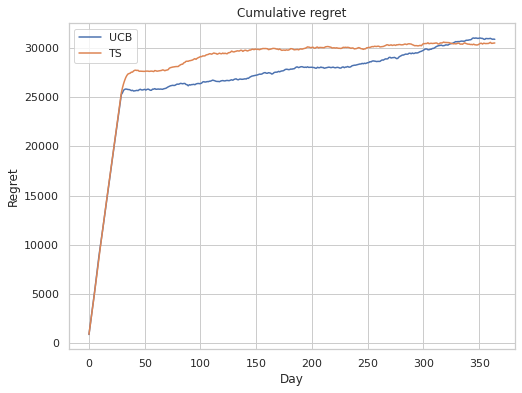

In [3]:
task.plot(0, figsize=(8,6))

As seen also by the reward graph, after around 30 days the optimal arm is almost always selected.

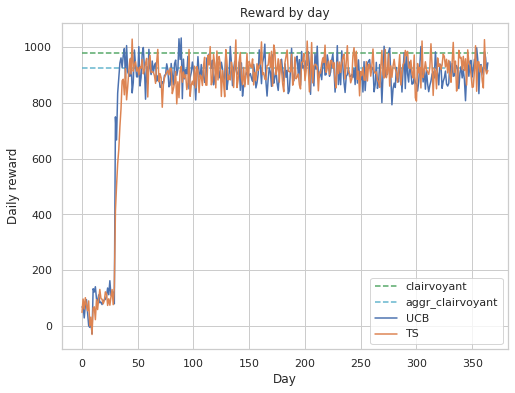

In [4]:
task.plot(1, figsize=(8,6))

# Context generation in pricing

Up to this point we considered users as they belonged to a unique class, disregarding the differences and peculiraties between the different classes of users. The algorithms used didn't indeed discriminate between the different classes and as a result it learned throught time the aggregated conversion rate $c$ and the aggregated $\tau$. We should look for a method to encode the different features in our algorithm in order to capture their differences and improve even more our performances. 
To do so we need first to introduce the concept of context.



### Context
As shown in the introduction every user is characterized by two binary features, which divides the feature subspace in $2^{2}=4$ parts.
By assigning specific values to the features we can define the classes of our users. In this way for example we defined class C1 as the the class with features _Online-Buyer=True_ and _Every-Day=True_. \
We define the context as a partition of the feature subspace according to some specific values of the features. A context might be a bigger feature subspace than a class and can group together many classes. In our case a context could be defined by _Online-Buyer=True_ and include both users belonging to C1 and to C2. \
Dividing the feature subspace in context might be beneficial for our approach to lighten the computational charge and fasten the calculations.

### Context generation
The number of possible partition(i.e. possible contexts) is although double exponential and we can't evaluate all of them. We need therefore an heuristic to guide us in our search throughout the feature space.
We found a possible solution in the greedy context generation algorithm, that works as follow:
1. For every feature
 * Evaluate the value after the split
3. Select the feature with the maximum value if larger than the non split case

So this algorithms looks for features that have not been already expanded in the current subspace, for everyone of them defines a value representing how valuable is the split on that feature and selects, if it exists, the feature with the maximum value.
At the end of the computation the result is a feature tree whose branches are the binary values of the features on which we splitted and the nodes are the different contexts.
This approach is said to be greedy cause it looks for the most promising feature, without exploring all the different feature trees that perform other feasible splits.

#### How do we perform the evalutation?
The evaluation is performed on the basis of what is defined as _split condition_. \
The split condition is formally defined as  
$$\underline{p_{c_1}}*\underline{μ_{a{c_1}^*,c_1}}+\underline{p_{c_2}}*\underline{μ_{a{c_2}^*,c_2}}\geq{\underline{μ_{a{c_0}^*,c_0}}}$$ \
with $\underline{p_{c_x}}$
being the probability that context $C_x$ occurs and $\underline{μ_{a{c_x}^*,c_x}}$ being the lower bound on the best expected reward for context $C_x$.
The two contexts $C_1$ and $C_2$ are the context that would be generated by the split and context $C_0$ is the context we are analyzing. 
The choice of the lower bound depends on the distribution. Having a finite distribution (Bernoulli) we used the Hoeffding bound
that is computed as $\overline{x} −\sqrt{\frac{log(δ)}{\mid2Z\mid}}$ where $δ$ is the confidence and $Z$ is the set of data.
The lower bound has been introduced to avoid splitting on conditions that do not significantly improve the performance.
The higher the confidence the lower will be the probability of choosing to split.



### Our implementation
In our scenario we implemented the above algorithms in the exact same way as it is described above.
The environment is the exact same of the one of the previous point and the only differences are in the learner. \
Indeed now our program starts from a parent node to which it corresponds a learner.
After a starting date $d$ the split condition is evaluated and, if the split is performed, two nodes corresponding to the partitions of the selected feature are generated. 
These two nodes will be two new learners themselves and they will be trained on the data available till that date, using only the data that complies with the constraint of the node's feature. \
Every node generated keeps track of the features that have been already expanded and the feature that are yet to be.
With a frequency $f$ new splits will be evaluated on the leaf nodes of the current graph until the time ends or the feature subspace is fully explored. \
The constraint on the starting date has been introduce to overcome the starting period of 30 days in which the learner doesn't fully capture the situation.
Every node will save the history of rewards until a split occurs in such a way that the rewards over all the time arc we are analazying can be computed using a top-to-bottom approach on the tree of learners.

### Performance evaluation
As in the aggregated scenario the arm to be pulled (i.e. the price) is chosen at the start of the day.
What differs instead is that now the regret is computed using as optimal the reward of the __disaggregated__ model. This reward will be computed using the $c_j$ and $\tau_j$ belonging to the class j. \
As shown in the reward plot the context generator is much more powerful compared to the previous model as it even exceeds the clairvoyant reward in the aggregated case. \
This is a proof of the upgrade in performances obtainted by following this approach.

In [5]:
src = 'src/basic007.json'
name = 'step4'
task_result = 'simulations_results/result_'+name+'_1.zip'

task = CompleteTask(data_src=src, name=name)
task.load(task_result);

Simulation's result loaded from `simulations_results/result_step4_1.zip`.


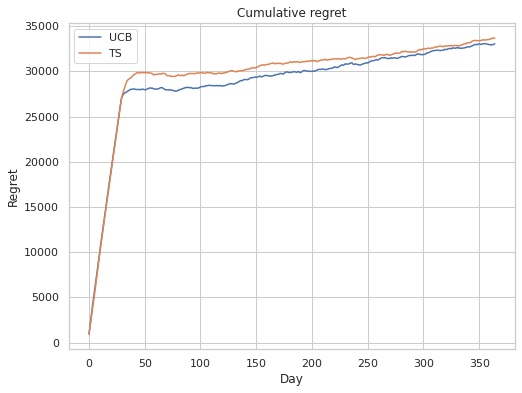

In [6]:
task.plot(0, figsize=(8,6))

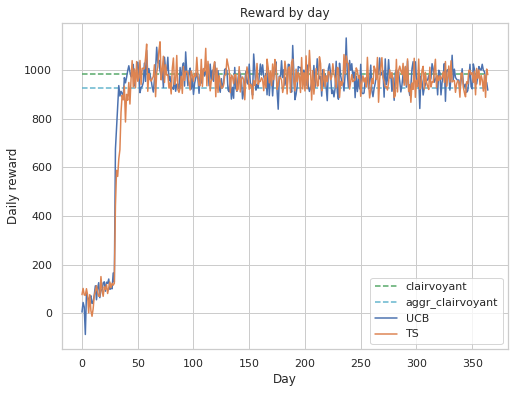

In [7]:
task.plot(1, figsize=(8,6))

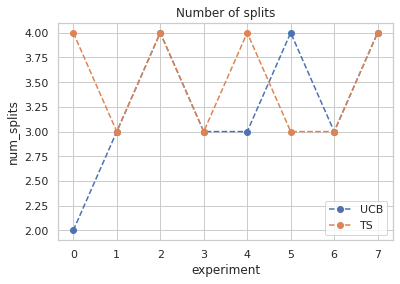

In [8]:
task.plot(2, figsize=(6,4))